In [2]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
df1 = pd.read_csv('dataset/df_prabowo_april_2025.csv', sep=';')
df1.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1917264334755094745,Tue Apr 29 17:06:53 +0000 2025,213,Anggota DPR Komisi II Komarudin WatoBun menila...,1917264334755094745,https://pbs.twimg.com/ext_tw_video_thumb/19172...,NaN,in,NaN,3,15,85,https://x.com/Nobody_2811/status/1917264334755...,1787788662295683072,Nobody_2811
1,1917231645486354588,Tue Apr 29 14:56:59 +0000 2025,137,Senin sore (28/4) saya menghadiri undangan per...,1917231645486354588,https://pbs.twimg.com/ext_tw_video_thumb/19172...,NaN,in,NaN,3,25,40,https://x.com/AgusYudhoyono/status/19172316454...,842986784,AgusYudhoyono
2,1917227526818316489,Tue Apr 29 14:40:37 +0000 2025,2361,Dulu LBP bgitu kejam ke Presiden @prabowo bahk...,1917227526818316489,https://pbs.twimg.com/media/GptcRQ7bgAAuKLZ.jpg,NaN,in,NaN,29,177,1010,https://x.com/bachrum_achmadi/status/191722752...,105085302,bachrum_achmadi
3,1917222387415945710,Tue Apr 29 14:20:12 +0000 2025,113,Karena saya cinta Polri makanya saya kritik. U...,1917222387415945710,https://pbs.twimg.com/ext_tw_video_thumb/19172...,NaN,in,NaN,1,1,45,https://x.com/_riverheaven/status/191722238741...,975389335775199232,_riverheaven
4,1917207823710388289,Tue Apr 29 13:22:19 +0000 2025,252,Setuju untuk mas Angga Raka Prabowo menjadi Ju...,1917207823710388289,NaN,NaN,in,NaN,1,22,54,https://x.com/PartaiSocmed/status/191720782371...,869327120,PartaiSocmed


# Text Preprocessing

In [6]:
df = pd.read_csv('dataset/text/prabowo_text11000.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10931 non-null  int64 
 1   full_text   10931 non-null  object
dtypes: int64(1), object(1)
memory usage: 170.9+ KB


In [8]:
df['label'].value_counts()

label
neutral     1971
negative    1450
positive     714
Name: count, dtype: int64

In [9]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Setup stemmer dan stopwords hanya sekali
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stpwds_id = set(stopwords.words("indonesian"))
tokenizer = RegexpTokenizer(r"\b[^\d\W]+\b")  # hanya ambil kata (bukan angka/simbol)

def text_proses_efisien(teks):
    teks = teks.lower()
    teks = re.sub(r'(@\w+|#\w+|http\S+|www.\S+|\\n|rt)', ' ', teks)
    teks = re.sub(r"[^a-zA-Z\s']", ' ', teks)  # hanya huruf dan spasi
    tokens = tokenizer.tokenize(teks)  # tokenizer cepat
    tokens = [t for t in tokens if t not in stpwds_id]
    stemmed_tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(stemmed_tokens)


In [7]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Inisialisasi hanya sekali
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stpwds_id = set(stopwords.words("indonesian"))
tokenizer = RegexpTokenizer(r"\b[^\d\W]+\b")

# Kompilasi regex untuk performa
re_pattern1 = re.compile(r'(@\w+|#\w+|http\S+|www.\S+|\\n|rt)')
re_pattern2 = re.compile(r"[^a-zA-Z\s']")

def preprocess_text(teks):
    teks = teks.lower()
    teks = re_pattern1.sub(' ', teks)
    teks = re_pattern2.sub(' ', teks)
    tokens = tokenizer.tokenize(teks)
    filtered = [t for t in tokens if t not in stpwds_id]
    stemmed = stemmer.stem(' '.join(filtered))  # stem sekaligus (lebih cepat!)
    return stemmed


In [8]:
import swifter

df['text_processed'] = df['full_text'].swifter.apply(preprocess_text)
df.head()

Pandas Apply: 100%|██████████| 10931/10931 [37:33<00:00,  4.85it/s] 


,Unnamed: 0,full_text,text_processed
0,0,OK gas ...Indonesia Emas nih pak @prabowo @gib...,ok gas indonesia emas nih l berkas kerja keras...
1,1,@uglygrunge1798 @Heraloebss @prabowo @gibran_t...,ngga hubung pilih presiden wapres puas pilih e...
2,2,@DedynurPalakka Kinerja? Emang pernah dikasih ...,kerja emang kasih tugas misi sm prabowo
3,3,@txtdrimedia Kinerja?? Emang dikasi tugas apa ...,kerja emang kasi tugas sm prabowo
4,4,@uglygrunge1798 @Heraloebss @prabowo @gibran_t...,demokrasi tupoksi kerja ndasmu pimpin yg tdk m...


In [9]:
df.to_csv("dataset/text/prabowo_text_processed.csv", index=False)

In [12]:
df_prabowo = pd.read_csv('prabowo_text_processed.csv')
df_prabowo['label_num'] = df_prabowo['label'].replace({'neutral' : 0, 'positive' : 1, 'negative' : 2})
df_prabowo.head()

,full_text,label,text_processed,label_num
0,So sweet Pak Prabowo dapat hadiah patung kucin...,positive,so sweet prabowo hadiah patung kucing perdana ...,1
1,@jilulisme Dari pas doi dki 1 udah kerasa pend...,positive,pas doi dki udah rasa dukung vibes nya dgn duk...,1
2,@AnKiiim_ Mohon Perhatiannya Pak @prabowo Bang...,positive,mohon perhati bang proses hukum sepe i patut n...,1
3,@prabowo Kami senang-bangga Bpk Presiden di sa...,positive,senang bangga bpk presiden sambut hangat kepal...,1
4,@hipohan Kami sbg warga Jabar masih percaya ko...,positive,sbg warga jabar percaya konsistensi kerja aing...,1


In [13]:
df_prabowo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4135 entries, 0 to 4134
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_text       4135 non-null   object
 1   label           4135 non-null   object
 2   text_processed  4135 non-null   object
 3   label_num       4135 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 129.3+ KB


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# 1. Inisialisasi dan fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

# 2. Tentukan MAX_WORDS berdasarkan jumlah kata unik
total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

# Atur MAX_WORDS agar tidak terlalu besar
if total_kata_unik > 20000:
    MAX_WORDS = 15000
elif total_kata_unik > 10000:
    MAX_WORDS = 10000
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 8803
MAX_WORDS yang digunakan: 8803


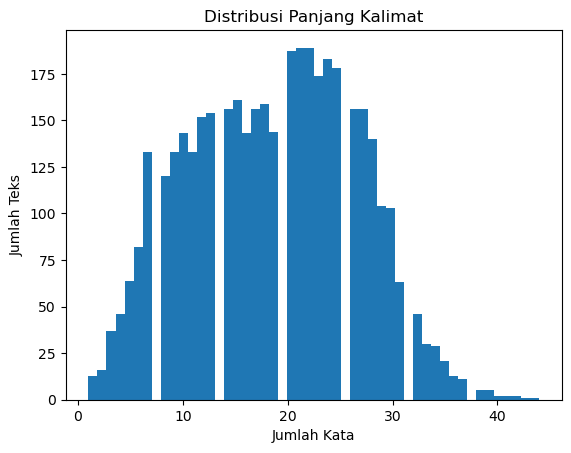

MAX_LEN (persentil 95): 31


In [19]:
# 3. Hitung panjang tiap kalimat
sequences = tokenizer.texts_to_sequences(df_prabowo['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

# 4. Tentukan MAX_LEN berdasarkan distribusi panjang
plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 95))
print("MAX_LEN (persentil 95):", MAX_LEN)

In [20]:
# 5. Lakukan ulang tokenizer dengan batasan MAX_WORDS
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_prabowo['text_processed'])
sequences = tokenizer.texts_to_sequences(df_prabowo['text_processed'])

# 6. Padding sequences
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Feature Engineering

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df_prabowo['label_num'], test_size=0.3, random_state=42, stratify=df_prabowo['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 0    1379
 2    1015
 1     500
 Name: count, dtype: int64,
 label_num
 0    592
 2    435
 1    214
 Name: count, dtype: int64)

# Model Architecture Definition

# Training Model

In [25]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([1379,  500, 1015], dtype=int64))


In [26]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6995407299975828, 1: 1.9293333333333333, 2: 0.9504105090311987}

In [38]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from keras.layers import BatchNormalization


model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN))

model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.4, recurrent_dropout=0.2)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3, activation='softmax'))

# Kompilasi model dengan learning rate yang lebih kecil
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights  
)

Epoch 1/100
91/91 [==============================] - 18s 119ms/step - loss: 1.3528 - accuracy: 0.4147 - val_loss: 1.0631 - val_accuracy: 0.6293
Epoch 2/100
91/91 [==============================] - 10s 114ms/step - loss: 0.8362 - accuracy: 0.6928 - val_loss: 0.8041 - val_accuracy: 0.6873
Epoch 3/100
91/91 [==============================] - 10s 112ms/step - loss: 0.4790 - accuracy: 0.8552 - val_loss: 0.8617 - val_accuracy: 0.6873
Epoch 4/100
91/91 [==============================] - 11s 120ms/step - loss: 0.2942 - accuracy: 0.9171 - val_loss: 0.8928 - val_accuracy: 0.6922
Epoch 5/100
91/91 [==============================] - 13s 138ms/step - loss: 0.2165 - accuracy: 0.9457 - val_loss: 0.9689 - val_accuracy: 0.7043
Epoch 6/100
91/91 [==============================] - 12s 134ms/step - loss: 0.1597 - accuracy: 0.9644 - val_loss: 1.0628 - val_accuracy: 0.7147
Epoch 7/100
91/91 [==============================] - 11s 124ms/step - loss: 0.1376 - accuracy: 0.9710 - val_loss: 1.1600 - val_accuracy:

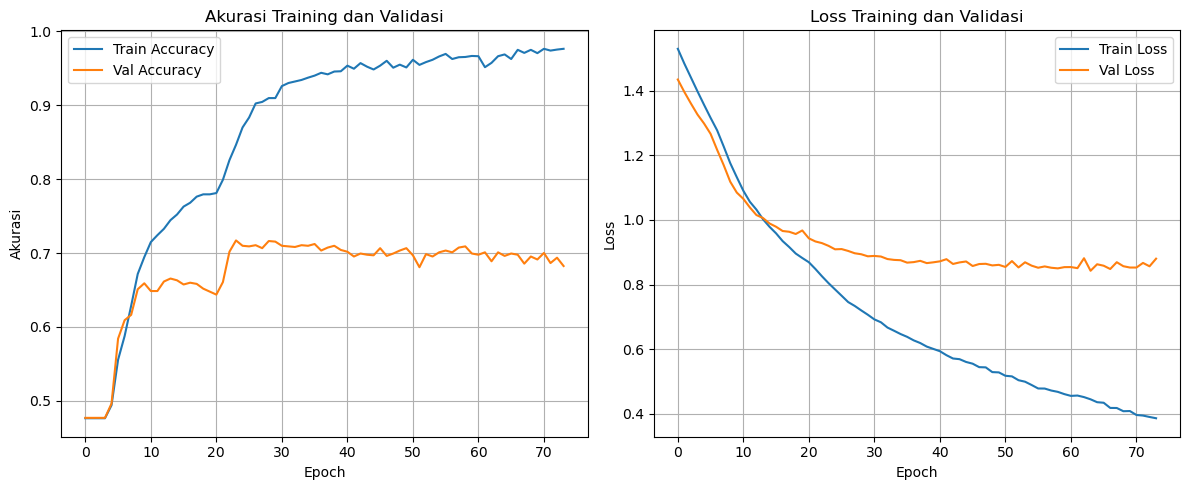

In [35]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


39/39 [==============================] - 1s 11ms/step


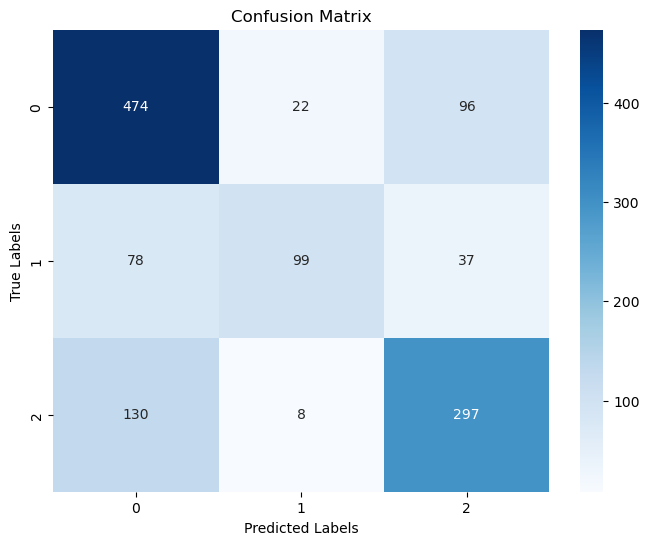

              precision    recall  f1-score   support

           0       0.70      0.80      0.74       592
           1       0.77      0.46      0.58       214
           2       0.69      0.68      0.69       435

    accuracy                           0.70      1241
   macro avg       0.72      0.65      0.67      1241
weighted avg       0.71      0.70      0.70      1241



In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Mengambil indeks dengan probabilitas tertinggi

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 4. Laporan klasifikasi (opsional tapi berguna)
print(classification_report(y_test, y_pred))


In [31]:
y_train[:5]

2251    0
226     1
3991    0
670     0
66      1
Name: label_num, dtype: int64